In [500]:
#importing packages ; holidays to identify the annual holidays ; requests to browse APIs
import holidays, requests
import polars as pl
import numpy as np
from bs4 import BeautifulSoup

# creating the list of important stations on Olso-Trondheim Line
station_cleaned_sorted = [ 'Oslo S', 'Lillestrøm', 'Gardermoen', 'Hamar', 'Brumunddal',   'Moelv',  'Lillehammer', 'Ringebu', 'Vinstra',  'Kvam', 'Otta',  'Dovre', 'Dombås', 'Hjerkinn',  'Kongsvoll',  'Oppdal', 'Berkåk','Støren',  'Heimdal',  'Trondheim']

# Creating the dictionary for station numbers between Oslo to Trondhiem Line
station_dict = {station_cleaned_sorted[i]: i for i in range(len(station_cleaned_sorted))}


def new_frost_key():
    params = {'email': 'pranjal.mandhaniya@ntnu.no'}
    r = requests.get('https://frost.met.no/auth/requestCredentials.html', params=params)
    curr_url = r.url
    #print(curr_url)
    html = str(r.text)
    soup = BeautifulSoup(html, "lxml")
    item = soup.select_one("code[id='key']").text
    return item
    #print(item)


#client_ID = '343b03b3-08ca-4155-9c31-6f8cfef4b34f'
def geolocation(search_term):
    parameters = { 'text': search_term+' Stasjon', 'lang': 'en', 'boundary.country':'NO'}  # https://search.mapzen.com/v1/search
    location = requests.get('https://api.entur.io/geocoder/v1/autocomplete', parameters) #.status_code  #.json() #['features'][0]['geometry']['coordinates']   #https://api.entur.io/geocoder/v1/search
    try:
        return location.json()['features'][0]['geometry']['coordinates'] 
    except KeyError:
        return geolocation(search_term)
        
locations_lat, locations_lon = [geolocation(i)[1] for i in station_cleaned_sorted], [geolocation(i)[0] for i in station_cleaned_sorted]
locations_lat, locations_lon = [i for i in locations_lat if i is not None], [i for i in locations_lon if i is not None]

def source(latitude, longitude, weather_type):  # 'mean(air_temperature P1D)' , 'sum(precipitation_amount P1D)', 'surface_snow_thickness'
    parameters1 = { 'geometry': 'nearest(POINT('+str(longitude)+' '+str(latitude)+'))','elements': weather_type,}
    try:
        source = requests.get('https://frost.met.no/sources/v0.jsonld', parameters1, auth=(new_frost_key(),'')).json()['data'][0]['id']
        return source
    except KeyError:
        return source(latitude, longitude, weather_type)

source_list_temp = [source(locations_lat[i], locations_lon[i], 'mean(air_temperature P1D)') for i in range(len(locations_lat))]
source_dict_temp = {station_cleaned_sorted[i]:source_list_temp[i] for i in range(len(source_list_temp))}

source_list_rain = [source(locations_lat[i], locations_lon[i], 'sum(precipitation_amount P1D)') for i in range(len(locations_lat))]
source_dict_rain = {station_cleaned_sorted[i]:source_list_rain[i] for i in range(len(source_list_rain))}

source_list_snow = [source(locations_lat[i], locations_lon[i], 'surface_snow_thickness') for i in range(len(locations_lat))]
source_dict_snow = {station_cleaned_sorted[i]:source_list_snow[i] for i in range(len(source_list_snow))}
#len(source_dict_snow), len(source_dict_rain), len(source_dict_temp), source_dict_snow


In [501]:
# Reading the arrival and departure data acquired from BaneNOR 
# The csv file can be downloaded from https://drive.google.com/file/d/1djfTDfKL2mqW9PT7suLRAbo7xf1v4vSq/view?usp=sharing
df = pl.read_csv('trains.csv', separator ='\t')
# remove all rows where the stations are not in the scope of list "station_cleaned_sorted"
df = df.filter(pl.col("Station").is_in(station_cleaned_sorted))
# filter the data by removing the null values from column "value"
df = df.filter(~pl.all(pl.col('value').is_null()))
# filter the data by removing the negatve values from column "value"
df = df.filter(pl.col("value") >= 0)
# Create a new column delay_grad from the departure delay column ("value" column) 
# if delay is more than -5 (early by 5 minutes) then the grade will be 1 and so on...
df = df.with_columns(
    pl.when( (pl.col("value") < 1)).then(pl.lit(1))
    .when( (pl.col("value") >= 1) & (pl.col("value") < 2) ).then(pl.lit(2))
    .when( (pl.col("value") >= 2) & (pl.col("value") <= 4) ).then(pl.lit(3))
    .when( (pl.col("value") > 5) ).then(pl.lit(4)) 
    .otherwise(pl.lit(0))
    .alias('delay_grad'))

# format the "Datetime" column to a specific format
df = df.with_columns(pl.col("Datetime").str.to_datetime("%Y-%m-%d %H:%M:%S"))
# Create time divisions (Day, month, week, hour) from the "Datetime"
df = df.with_columns(
    [
        pl.col("Datetime").dt.weekday().alias("weekday"),
        pl.col("Datetime").dt.month().alias("month"),
        pl.col("Datetime").dt.hour().alias("hour"),
        pl.col("Datetime").dt.week().alias("week"),
        pl.col("Datetime").dt.date().alias("Date"),
    ]
)
# remove unrequired columns from the dataframe
df = df.drop(['Actual_dep', 'Year', 'Sequence', 'Planned_dep', 'Planned_arr', 'Actual_arr', 'Train_set', 'Arr_delay'])
# Create  a new dataframe by filtering the data by selecting the values greater than -1000 from column "value"
df_small = df.filter(pl.col('value')> -1000)
# Create 25% and 75% quantile values from this new dataframe 
q1, q3 = df_small['value'].quantile(0.25), df_small['value'].quantile(0.75) 
# Create lower and upper boundary from these 25% and 75% quantile values
lower_boundary, upper_boundary = q1 - 1.5*(q3-q1) , q3 + 1.5*(q3-q1)
# Filter the original dataframe to select the value in these boundaries
df = df_small.filter((pl.col("value") > lower_boundary) & (pl.col("value") < upper_boundary))
# create a new column 'Station_num' using the dictionary "station_dict" 
df = df.with_columns(pl.col("Station").map_dict(station_dict).alias('Station_num'))
# create a column to record if a date i holiday or not
df = df.with_columns(pl.col('Datetime').apply(lambda i: i.date() in holidays.NO(years = i.year).keys()).alias('is_holiday'))
# Create a new dataframe with selected columns
test_df = df[['Datetime', 'Train_num','delay_grad','Station_num','weekday','value', 'Direction_0', 'Direction_1', 'is_holiday','month']]
test_df = test_df.drop_nulls()
#test_df.shape  
#df

In [502]:
# create a new column 'Source_Code_temp' using the dictionary "source_dict_temp" 
df = df.with_columns(pl.col("Station").map_dict(source_dict_temp).alias('Source_Code_temp'))
# create a new column 'Source_Code_rain' using the dictionary "source_dict_rain" 
df = df.with_columns(pl.col("Station").map_dict(source_dict_rain).alias('Source_Code_rain'))
# create a new column 'Source_Code_snow' using the dictionary "source_dict_snow" 
df = df.with_columns(pl.col("Station").map_dict(source_dict_snow).alias('Source_Code_snow'))
# create a new columns by joining the waetehr source code and the date of travel. 
df = df.with_columns( pl.struct(["Source_Code_temp", "Date"]).apply(lambda cols: str(cols["Source_Code_temp"]) +';'+ str(cols["Date"]) ).alias("temperature"),
                      pl.struct(["Source_Code_rain", "Date"]).apply(lambda cols: str(cols["Source_Code_rain"]) +';'+ str(cols["Date"]) ).alias("rainfall"),
                      pl.struct(["Source_Code_snow", "Date"]).apply(lambda cols: str(cols["Source_Code_snow"]) +';'+ str(cols["Date"]) ).alias("snowfall"),
                      )
# Get list of unique date from 'Date' column
df_dt = list(df['Date'].unique())
# Create date 
date_input = str(min(df_dt))+'/'+str(max(df_dt))
source_list_input_temp, source_list_input_rain, source_list_input_snow = '', '', ''
for i in source_list_temp:
    source_list_input_temp = i+','+source_list_input_temp
for i in source_list_rain:
    source_list_input_rain = i+','+source_list_input_rain
for i in source_list_snow:
    source_list_input_snow = i+','+source_list_input_snow

In [503]:
import random, time
def new_frost_key():
    emails = [ 'pranjalmandhaniya@gmail.com','pranjalmandhaniya1@gmail.com']
    params = {'email': random.choice(emails)}
    r = requests.get('https://frost.met.no/auth/requestCredentials.html', params=params)
    curr_url = r.url
    #print(curr_url)
    html = str(r.text)
    soup = BeautifulSoup(html, "lxml")
    item = soup.select_one("code[id='key']").text
    return item

def weather_element(source,date, weather_type): # 'mean(air_temperature P1D)' , 'sum(precipitation_amount P1D)', 'surface_snow_thickness'
    parameters = {'sources': source,'elements': weather_type,  'referencetime': date,}
    try:
        reqst = requests.get('https://frost.met.no/observations/v0.jsonld', parameters, auth=(new_frost_key(),''))
        elmnt = reqst.json()['data'] #[0]['observations'][0]['value']  #[0]['value']
        return elmnt
    except KeyError:
        return weather_element(source,date, weather_type)

print(source_list_input_rain, date_input)
rain_data_dict = weather_element(source_list_input_rain, date_input, 'sum(precipitation_amount P1D)')
print('rain')
rain_dict = {}
for i in rain_data_dict:
    rain_dict[str(i['sourceId'].split(':')[0]) +';'+ str(i['referenceTime'].split('T')[0])] = float(i['observations'][0]['value'] )
df = df.with_columns(pl.col("rainfall").map_dict(rain_dict).alias('rainfall'))

temp_data_dict = weather_element(source_list_input_temp, date_input, 'mean(air_temperature P1D)' )
print('temp')
temp_dict = {}
for i in temp_data_dict:
    temp_dict[str(i['sourceId'].split(':')[0]) +';'+ str(i['referenceTime'].split('T')[0])] = float(i['observations'][0]['value'] )
df = df.with_columns(pl.col("temperature").map_dict(temp_dict).alias('temperature'))
df = df.with_columns(
    pl.when( (pl.col("temperature") < -15)).then(pl.lit(1))
    .when( (pl.col("temperature") >= -15) & (pl.col("temperature") < 0) ).then(pl.lit(2))
    .when( (pl.col("temperature") >= 0) & (pl.col("temperature") <= 15) ).then(pl.lit(3))
    .when( (pl.col("temperature") > 15) ).then(pl.lit(4)) 
    .otherwise(pl.lit(0))
    .alias('temp_grad'))

df = df.with_columns(
    pl.when( (pl.col("rainfall") < 5)).then(pl.lit(1))
    .when( (pl.col("rainfall") >= 5) & (pl.col("rainfall") < 15) ).then(pl.lit(2))
    .when( (pl.col("rainfall") >= 15) & (pl.col("rainfall") <= 30) ).then(pl.lit(3))
    .when( (pl.col("rainfall") > 30) ).then(pl.lit(4)) 
    .otherwise(pl.lit(0))
    .alias('rain_grad'))

'''
snow_data_dict = weather_element(source_list_input_snow, date_input, 'surface_snow_thickness' )
print('snow')
snow_dict = {}
for i in snow_data_dict:
    snow_dict[str(i['sourceId'].split(':')[0]) +';'+ str(i['referenceTime'].split('T')[0])] = float(i['observations'][0]['value'] )
df = df.with_columns(pl.col("snowfall").map_dict(snow_dict).alias('snowfall'))
'''
# Create a new dataframe with selected columns
test_df1 = df[['Datetime', 'Train_num','Station_num','delay_grad','rain_grad','temp_grad','weekday','value', 'Direction_0', 'Direction_1','week','hour','temperature','rainfall']]  
test_df2 = df[['Datetime', 'Train_num','Station_num','weekday','value', 'Direction_0', 'Direction_1','week','hour','temperature','rainfall']] 
test_df3 = df[['Datetime', 'Train_num','Station_num','weekday','delay_grad','temp_grad','value', 'Direction_0', 'Direction_1','week','hour','temperature']]  
test_df4 = df[['Datetime', 'Train_num','Station_num','weekday','value', 'delay_grad','rain_grad','Direction_0', 'Direction_1','week','hour','rainfall']]  
test_df1, test_df2, test_df3 = test_df1.drop_nulls(), test_df2.drop_nulls(), test_df3.drop_nulls()
test_df1.shape

SN69100,SN68120,SN67280,SN66620,SN63705,SN9310,SN9310,SN16560,SN16400,SN16040,SN16040,SN13655,SN13150,SN12648,SN12600,SN12320,SN12290,SN4781,SN4110,SN18317, 2021-01-01/2023-02-28
rain
temp


(66330, 14)

In [504]:
df.describe()

describe,Datetime,Date,Train_num,Station,Station_code,value,Direction_0,Direction_1,delay_grad,weekday,month,hour,week,Station_num,is_holiday,Source_Code_temp,Source_Code_rain,Source_Code_snow,temperature,rainfall,snowfall,temp_grad,rain_grad
str,str,str,f64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,str,f64,f64,str,f64,f64
"""count""","""81571""","""81571""",81571.0,"""81571""","""81571""",81571.0,81571.0,81571.0,81571.0,81571.0,81571.0,81571.0,81571.0,81571.0,81571.0,"""81571""","""81571""","""81571""",81571.0,81571.0,"""81571""",81571.0,81571.0
"""null_count""","""0""","""0""",0.0,"""0""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""0""","""0""","""0""",9146.0,6306.0,"""0""",0.0,0.0
"""mean""",null,null,45.335708,null,null,2.541052,0.499356,0.500644,2.065268,3.853551,6.163232,14.991517,25.081156,9.662478,0.027645,null,null,null,3.224359,1.615795,null,2.410783,1.035123
"""std""",null,null,2.88147,null,null,2.393473,0.500003,0.500003,1.207718,1.994453,3.68914,4.170273,16.103373,5.554513,0.16395,null,null,null,9.139185,3.935296,null,1.076465,0.48057
"""min""","""2021-01-01 13:…","""2021-01-01""",40.0,"""Berkåk""","""BRD""",0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,"""SN12290""","""SN12290""","""SN12320""",-28.1,0.0,"""SN12320;2021-0…",0.0,0.0
"""max""","""2023-02-28 23:…","""2023-02-28""",51.0,"""Vinstra""","""VIN""",10.78,1.0,1.0,4.0,7.0,12.0,23.0,53.0,19.0,1.0,"""SN9310""","""SN9310""","""SN9310""",25.3,64.3,"""SN9310;2023-02…",4.0,4.0
"""median""",null,null,46.0,null,null,1.75,0.0,1.0,2.0,4.0,6.0,15.0,25.0,10.0,0.0,null,null,null,3.0,0.1,null,3.0,1.0
"""25%""",null,null,43.0,null,null,0.71,0.0,0.0,1.0,2.0,3.0,12.0,9.0,5.0,null,null,null,null,-2.8,0.0,null,2.0,1.0
"""75%""",null,null,47.0,null,null,3.7,1.0,1.0,3.0,5.0,9.0,18.0,40.0,15.0,null,null,null,null,10.4,1.3,null,3.0,1.0


In [479]:
import torch as T
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

###################### Part-2  ###################### 
#####################################################  
# A function to split data into training, testing and validation dataset. Training and validation data ratio are equal.
def train_val_test_split(df, target_col, test_ratio):
    # Seperate the features that will be used to predict (X) the value (y) 
    X, y = df.drop(columns=[target_col]), df[[target_col]]
    # Split the training (X_train, y_train) and testing (X_test, y_test) datasets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, shuffle=False)
    # Split the training (X_train, y_train) data into validation (X_val, y_val) and training (X_train, y_train) datasets
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=test_ratio, shuffle=False)
    #v Return the training, testing and validation datasets 
    return X_train, X_val, X_test, y_train, y_val, y_test

# Use the function "train_val_test_split" to split dataset "test_df"
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(test_df1, 'value', 0.15)

# Use a scaler type to convert the data to numpy equivalent arrays (easy for calculation and scaling)
scaler = MinMaxScaler() # MinMaxScaler(), StandardScaler(), MaxAbsScaler(), RobustScaler()

# Transform the training, testing and validation dataset to arrays using the scaler (X)
X_train_arr, X_val_arr, X_test_arr = scaler.fit_transform(X_train), scaler.transform(X_val), scaler.transform(X_test)
# Transform the training, testing and validation dataset to arrays using the scaler (y)
y_train_arr, y_val_arr, y_test_arr = scaler.fit_transform(y_train), scaler.transform(y_val), scaler.transform(y_test)

# Convert the array to tensor (training data)
train_features, train_targets = T.Tensor(X_train_arr), T.Tensor(y_train_arr)
# Convert the array to tensor (validation data)
val_features, val_targets = T.Tensor(X_val_arr), T.Tensor(y_val_arr)
# Convert the array to tensor (testing data)
test_features, test_targets = T.Tensor(X_test_arr), T.Tensor(y_test_arr)

# Pool the tensors into tensor datasets (training data)
train = TensorDataset(train_features, train_targets)
# Pool the tensors into tensor datasets (validation data)
val = TensorDataset(val_features, val_targets)
# Pool the tensors into tensor datasets (testing data)
test = TensorDataset(test_features, test_targets)

# Assign batch size for modelling
batch_size = 64
# Create a DataLoader class for prediction modelling (training data)
train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
# Create a DataLoader class for prediction modelling (validation data)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
# Create a DataLoader class for prediction modelling (testing data)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)


In [480]:
import torch.optim as optim
from production.models import *
from production.training import *
#from super_utils import *
import torch as T
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from skorch import NeuralNetRegressor

###################### Part-3  ###################### 
#####################################################  
# Input data for the prediction model
# variables used as features (input_dim)
input_dim = len(X_train.columns)
# variables to be predicted (output_dim)
output_dim = 1
# other prediction related parameters 
num_hidden = 64
num_layer = 3
batch_size = 64
drop_prob = 0.2
n_epochs = 6
learning_rate = 1e-4
weight_decay = 1e-6

# assign the parameters into a dictionary
model_params = {'input_dim': input_dim,
                'num_hidden' : num_hidden,
                'num_layer' : num_layer,
                'output_dim' : output_dim,
                'drop_prob' : drop_prob}

# Call the function to choose from the prediction methods
# LSTM model
model_lstm = get_model('lstm', model_params)

# Use CUDA is its available for parallel running of code
device = T.device('cuda' if T.cuda.is_available() else 'cpu')

# Define a Loss function
loss_function = nn.MSELoss(reduction = "mean")

# Define an optimizer function
# LSTM model
optimizer_lstm = optim.Adam(model_lstm.parameters(), lr = learning_rate, weight_decay=weight_decay)

# Pool the prediction model, loss function and optimizer to create the optimization function
# LSTM model
opt_lstm = Optimization(model=model_lstm, loss_function=loss_function, optimizer=optimizer_lstm)

# Train the optimization function 
# LSTM model
opt_lstm.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)

Epoch 2:  17%|█▋        | 1/6 [00:11<00:59, 11.82s/epoch]

[0/6] Training loss: 0.0483	 Validation loss: 0.0434


Epoch 3:  33%|███▎      | 2/6 [00:23<00:47, 11.75s/epoch]

[1/6] Training loss: 0.0325	 Validation loss: 0.0219


Epoch 4:  50%|█████     | 3/6 [00:35<00:35, 11.77s/epoch]

[2/6] Training loss: 0.0212	 Validation loss: 0.0184


Epoch 5:  67%|██████▋   | 4/6 [00:47<00:23, 11.81s/epoch]

[3/6] Training loss: 0.0184	 Validation loss: 0.0157


Epoch 6:  83%|████████▎ | 5/6 [00:59<00:11, 11.86s/epoch]

[4/6] Training loss: 0.0162	 Validation loss: 0.0139


Epoch 6: 100%|██████████| 6/6 [01:11<00:00, 11.86s/epoch]

[5/6] Training loss: 0.0150	 Validation loss: 0.0130


In [481]:
# getting the predictions and value from the models
# LSTM model
predictions_lstm, values = opt_lstm.evaluate(test_loader, batch_size=batch_size, n_features=input_dim)

vals = [item[0] for sublist in values for item in sublist]
preds_lstm = [item[0] for sublist in predictions_lstm for item in sublist]

size = abs(X_test.shape[0]-len(vals))

vals.extend([None]*size)
preds_lstm.extend([None]*size)

df_result = X_test.with_columns(pl.Series(name="value", values=vals), pl.Series(name="prediction_lstm", values=preds_lstm),  )
df_result = df_result.with_columns(pl.Series(name="value", values=[item[0] for item in scaler.inverse_transform(df_result.select('value'))] ), 
pl.Series(name="prediction_lstm", values=[item[0] for item in scaler.inverse_transform(df_result.select('prediction_lstm'))]), )
df_result = df_result.filter(pl.col("value").is_not_nan())



In [483]:

def calculate_metrics(df, model):
    result_metrics = {'mae' : mean_absolute_error(df["value"], df["prediction"+'_'+model]),
                      'rmse' : mean_squared_error(df["value"], df["prediction"+'_'+model]) ** 0.5 ,
                      'r2' : r2_score(df["value"], df["prediction"+'_'+model])}
    print("Model:                     ", model)
    print("Mean Absolute Error:       ", result_metrics["mae"])
    print("Root Mean Squared Error:   ", result_metrics["rmse"])
    print("R^2 Score:                 ", result_metrics["r2"])
    return result_metrics
    
result_metrics_lstm = calculate_metrics(df_result,'lstm')



Model:                      lstm
Mean Absolute Error:        0.9366884445556977
Root Mean Squared Error:    1.2981814568526038
R^2 Score:                  0.741140813698466


In [499]:
#for col in ["value", "prediction"]:
df_result = df_result.with_columns(pl.Series(name="value", values=[item[0] for item in scaler.inverse_transform(df_result.select('value'))] ), pl.Series(name="prediction_lstm", values=[item[0] for item in scaler.inverse_transform(df_result.select('prediction_lstm'))] ) )
#type( [item[0] for item in scaler.inverse_transform(df_result.select('value'))]  )
#df_result = df_result.with_columns( scaler.inverse_transform(df_result.select('value')) )
#df_result["value"] = df_result["value"]
#df_result["value"] = scaler.inverse_transform()

#print(df_result.head(2))


C:\Users\pranjalm\AppData\Local\Temp\3\ipykernel_29920\441132158.py:3: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.AutoDateLocator'>
  plt.locator_params(nbins=5, axis='x')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


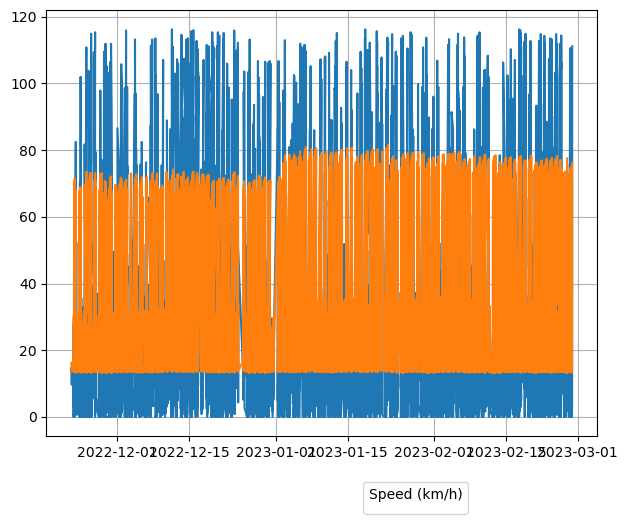

In [487]:
plt.plot(df_result.select('Datetime'),df_result.select('value'))
plt.plot(df_result.select('Datetime'),df_result.select('prediction_lstm'))
plt.locator_params(nbins=5, axis='x')
plt.tight_layout()
plt.grid(True)
plt.legend(title="Speed (km/h)", bbox_to_anchor=(0.75,0), fontsize=10, ncol=4, bbox_transform=plt.gcf().transFigure)
plt.savefig('delay_prediction.eps', bbox_inches="tight",format='eps', dpi=1200)  
plt.show()

Various efforts to plot higher level patterns in the predictions:

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


shape: (15, 15)
┌──────┬───────────────┬───────────┬───────────┬───┬───────────┬──────────┬───────────┬────────────┐
│ week ┆ Datetime      ┆ Train_num ┆ Station_n ┆ … ┆ temperatu ┆ rainfall ┆ value     ┆ prediction │
│ ---  ┆ ---           ┆ ---       ┆ um        ┆   ┆ re        ┆ ---      ┆ ---       ┆ _lstm      │
│ u32  ┆ datetime[μs]  ┆ f64       ┆ ---       ┆   ┆ ---       ┆ f64      ┆ f64       ┆ ---        │
│      ┆               ┆           ┆ f64       ┆   ┆ f64       ┆          ┆           ┆ f64        │
╞══════╪═══════════════╪═══════════╪═══════════╪═══╪═══════════╪══════════╪═══════════╪════════════╡
│ 1    ┆ null          ┆ 45.329457 ┆ 9.455426  ┆ … ┆ -8.662016 ┆ 2.176744 ┆ 33.278027 ┆ 34.019001  │
│ 2    ┆ null          ┆ 45.339683 ┆ 9.712698  ┆ … ┆ -0.708571 ┆ 1.782381 ┆ 25.215447 ┆ 27.715985  │
│ 3    ┆ null          ┆ 45.471223 ┆ 9.242806  ┆ … ┆ -8.44964  ┆ 0.752158 ┆ 25.968555 ┆ 28.884534  │
│ 4    ┆ null          ┆ 45.513261 ┆ 9.463339  ┆ … ┆ -3.353666 ┆ 0.731201 ┆

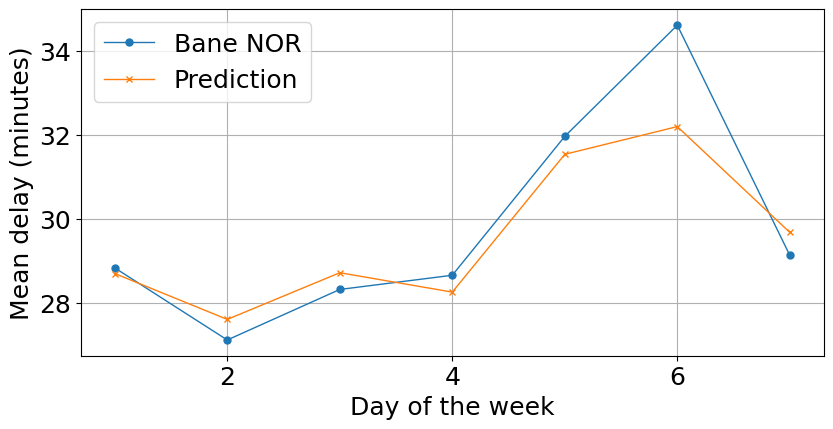

In [498]:
grouped_week = df_result.groupby('week', maintain_order=False).mean() 
grouped_day = df_result.groupby('weekday', maintain_order=False).mean() 
print(grouped_week)

plt.figure(figsize=(8, 4))
plt.plot(grouped_day.select('weekday'),grouped_day.select('value'), label='Bane NOR', marker='o', linestyle='-', linewidth=1, markersize=5)
plt.plot(grouped_day.select('weekday'),grouped_day.select('prediction_lstm'), label='Prediction', marker='x', linestyle='-', linewidth=1, markersize=5)
plt.locator_params(nbins=5, axis='x')
plt.tight_layout()
plt.grid(True)
plt.tick_params( labelsize= 18)
plt.xlabel('Day of the week', fontsize=18)
plt.ylabel('Mean delay (minutes)', fontsize=18)
#plt.title('Mean Actual Delays and Predictions')
plt.legend(fontsize=18) # bbox_to_anchor=(0.75,0), fontsize=10, ncol=4, bbox_transform=plt.gcf().transFigure)
plt.savefig('weekday_wise.eps', bbox_inches="tight",format='eps', dpi=1200)  
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


shape: (12,)
Series: 'month' [u32]
[
	1
	2
	3
	4
	5
	6
	7
	8
	9
	10
	11
	12
]


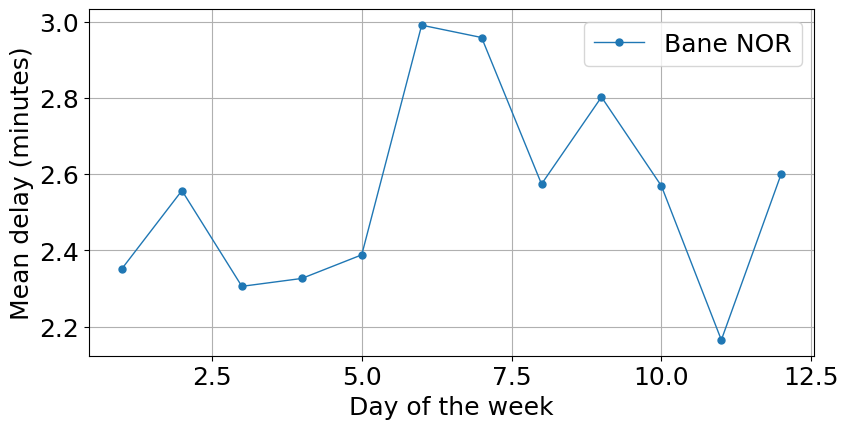

In [ ]:
grouped_week = df.groupby('week', maintain_order=True).mean() 
grouped_week.sort('week')
print(grouped_week)

plt.figure(figsize=(8, 4))
plt.plot(grouped_week['month'],grouped_week['value'], label='Bane NOR', marker='o', linestyle='-', linewidth=1, markersize=5)
#plt.plot(grouped_week.select('week'),grouped_week.select('prediction_lstm'), label='Prediction', marker='x', linestyle='-', linewidth=1, markersize=5)
plt.locator_params(nbins=5, axis='x')
plt.tight_layout()
plt.grid(True)
plt.tick_params( labelsize= 18)
plt.xlabel('Day of the week', fontsize=18)
plt.ylabel('Mean delay (minutes)', fontsize=18)
#plt.title('Mean Actual Delays and Predictions')
plt.legend(fontsize=18) # bbox_to_anchor=(0.75,0), fontsize=10, ncol=4, bbox_transform=plt.gcf().transFigure)
plt.savefig('weekday_wise.eps', bbox_inches="tight",format='eps', dpi=1200)  
plt.show()





The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


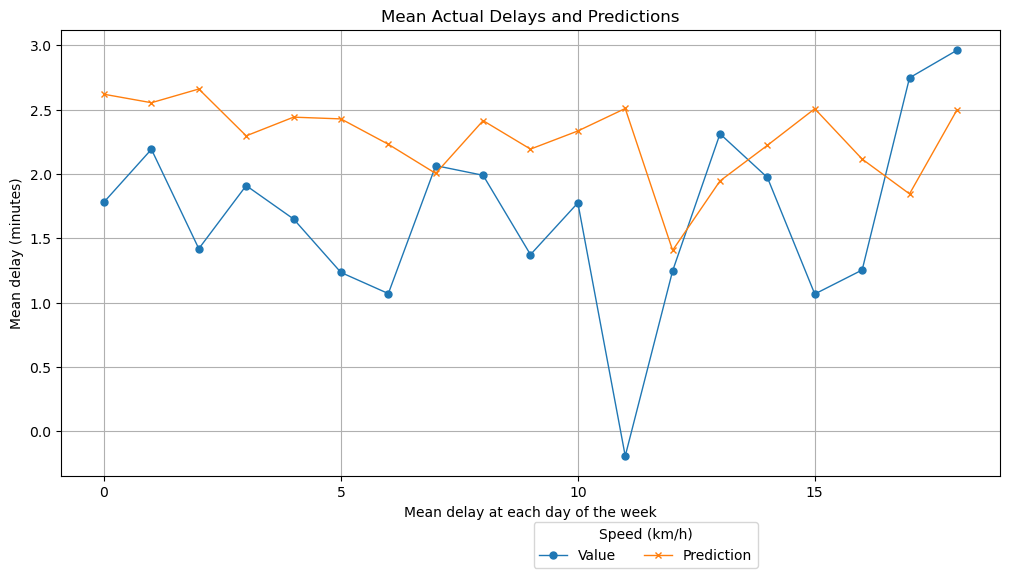

In [814]:
csfont = {'fontname':'Times New Roman'}
plt.figure(figsize=(10, 5))
plt.plot(desc_df.select('Station'),desc_df.select('value'), label='Value', marker='o', linestyle='-', linewidth=1, markersize=5)
plt.plot(desc_df.select('Station'),desc_df.select('prediction'), label='Prediction', marker='x', linestyle='-', linewidth=1, markersize=5)
plt.locator_params(nbins=5, axis='x')
plt.tight_layout()
plt.grid(True)
plt.xlabel('Mean delay at each day of the week')
plt.ylabel('Mean delay (minutes)')
plt.title('Mean Actual Delays and Predictions')
plt.legend()
plt.legend(title="Speed (km/h)", bbox_to_anchor=(0.75,0), fontsize=10, ncol=4, bbox_transform=plt.gcf().transFigure)
plt.savefig('delay_prediction.eps', bbox_inches="tight",format='eps', dpi=1200)  
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


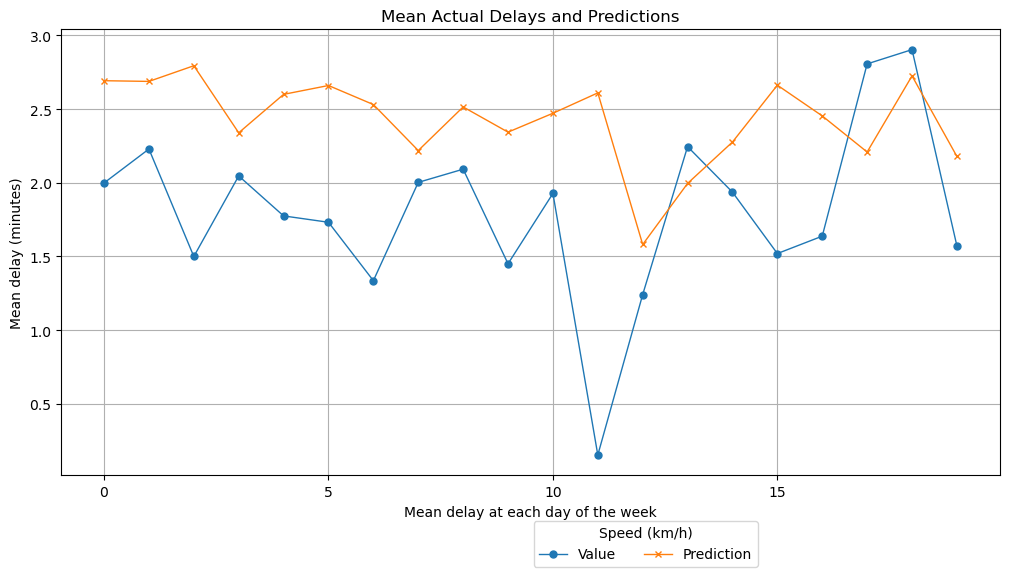

In [815]:
csfont = {'fontname':'Times New Roman'}
plt.figure(figsize=(10, 5))
plt.plot(grouped_weekday.select('Station'),grouped_weekday.select('value'), label='Value', marker='o', linestyle='-', linewidth=1, markersize=5)
plt.plot(grouped_weekday.select('Station'),grouped_weekday.select('prediction'), label='Prediction', marker='x', linestyle='-', linewidth=1, markersize=5)
plt.locator_params(nbins=5, axis='x')
plt.tight_layout()
plt.grid(True)
plt.xlabel('Mean delay at each day of the week')
plt.ylabel('Mean delay (minutes)')
plt.title('Mean Actual Delays and Predictions')
plt.legend()
plt.legend(title="Speed (km/h)", bbox_to_anchor=(0.75,0), fontsize=10, ncol=4, bbox_transform=plt.gcf().transFigure)
plt.savefig('delay_prediction.eps', bbox_inches="tight",format='eps', dpi=1200)  
plt.show()

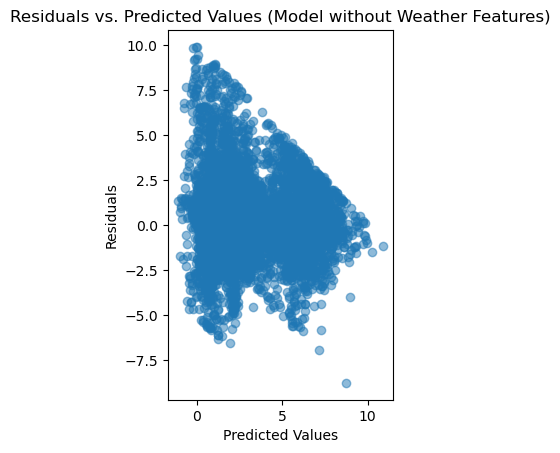

In [38]:
import matplotlib.pyplot as plt


# Calculate residuals
df['residuals_without_weather'] = df['value'] - df['prediction']
#df['residuals_without_weather'] = df['actual_values'] - df['predictions_without_weather']

# Plot residuals
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.scatter(df['predictions_with_weather'], df['residuals_with_weather'], alpha=0.5)
# plt.xlabel('Predicted Values')
# plt.ylabel('Residuals')
# plt.title('Residuals vs. Predicted Values (Model with Weather Features)')

plt.subplot(1, 2, 2)
plt.scatter(df['prediction'], df['residuals_without_weather'], alpha=0.5)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values (Model without Weather Features)')

plt.show()